In [1]:
import gym
from matplotlib.ticker import MaxNLocator
from gym import envs
from gym import wrappers, logger
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torchvision.transforms as T
from PIL import Image
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
from utility import Config_DQN
from agent.dqnagent import Agent
from collections import deque
from tqdm import tqdm
from pathlib import Path
from utility import get_unique_numbers
import time
################################## set device ##################################
print("============================================================================================")
# set device to cpu or cuda
if(torch.cuda.is_available()): 
    device = torch.device('cuda:0') 
    torch.cuda.empty_cache()
    print("Device set to : " + str(torch.cuda.get_device_name(device)))
else:
    device = torch.device('cpu')
    print("Device set to : cpu")
print("============================================================================================")


c:\Users\lynch\anaconda3\envs\DQN_win\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Device set to : NVIDIA GeForce RTX 3070 Laptop GPU


# Folder

In [8]:
# create folder
file_name = 'DQN' # Folder name
p_model = (Path()/ 'document'/'model'/file_name) # storage under model directory
p_model.mkdir(parents=True, exist_ok=True) # create if no directory existed


# Track
# load_tracks_from=TRACK -- Load a specific map from a pkl file
TRACK = 'track'

# ENV
# Gym make the environment
frame = int(1) # state is frame - 1
env = gym.make('CarRacing-v0', num_obstacles=100, show_info_panel=1,
               num_tracks=1, num_lanes=1, discretize_actions='soft', 
               allow_outside=False, grayscale=1, frames_per_state=frame,load_tracks_from = TRACK)

observation_space = env.observation_space.shape
action_space = env.action_space.n

# Parameters
""" configuration of parameter setup, and setup training configuration. """
# modify under
Episode_train = 100           # Total training episodes
Model_Save_frequency = 20    # the frequency of saving model under directory
Time_stamp = 500            # Exploring time stamps
seed = 32

cfg = Config_DQN(print_ep=1, freq_save_epi=Model_Save_frequency, n_episodes=Episode_train, GAMMA=0.95, SEED=seed, eps_end=0.001, max_t=Time_stamp)
setattr(cfg, 'state_size', observation_space)
setattr(cfg, 'action_size', action_space) 

# Create an agent
agent = Agent(cfg)


if p_model.is_dir():
    nb_name = 'log_par.txt'
    with open(p_model.joinpath(nb_name), "w") as f:
        f.write('-----------------------Var Config-----------------------\n')
        for key, value in vars(cfg).items(): 
            f.write('%s:%s\n' % (key, value))
        f.write('-----------------------Var Env-----------------------\n')
        for key, value in vars(env).items():
            f.write('%s:%s\n' % (key, value))
        f.write('-----------------------Var File-----------------------\n')
        f.write('Directroy: %s,\n'% p_model)
        f.write('SOFT_NEG_REWARD = 0.1, \nOut side: -1, \nreward += ((((left | right) & not_visited).sum()+0.4)/ factor),\n max_time_out = 10.0,\ncheck_outside == False\n')
        print('Log File was created.')
        f.close()
else:
    print("Directory doesn\'t exist.")

Log File was created.


# DQN train function

In [9]:
def DQN(cfg):
    n_episodes = cfg.n_episodes
    max_t = cfg.max_t
    eps_start= cfg.eps_start
    scores_deque = deque(maxlen=100)
    scores = []
    avg_scores = []
    eps = eps_start

    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            next_state, reward, done, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            
            score += reward
            if done:
                break
        scores_deque.append(score)
        scores.append(score)
        eps = max(cfg.eps_end, cfg.eps_decay*eps) # decrease epsilon        
        avg_scores.append(np.mean(scores_deque))
        if i_episode % cfg.print_ep ==0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))   
        if i_episode % cfg.freq_save_epi == 0:
            local_name = f'DQN_local{i_episode}.pth'
            torch.save(agent.qnetwork_local.state_dict(), (p_model/local_name))

    return scores,avg_scores, agent

## Start training

In [10]:
from utility import score_save

start = time.time()
scores,avg_scores, agent = DQN(cfg)
end = time.time()
score_save(scores, averagescore=avg_scores, file_name=file_name, path=p_model, print_=False)
hours, rem = divmod(end-start, 3600)
minutes, seconds = divmod(rem, 60)
print("Total training time: {:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))


if p_model.is_dir():
    nb_name = 'Run_log_training.txt'
    with open(p_model.joinpath(nb_name), "w") as f:
        f.write("Total training time: {:0>2}:{:0>2}:{:05.2f}\n".format(int(hours),int(minutes),seconds))
        f.write('Toal epoch:%s\n'%cfg.n_episodes)
        f.write('Csv file name:%s\n'%file_name)
        f.close()

Episode 1	Average Score: 82.00
Episode 2	Average Score: 82.00
Episode 3	Average Score: 82.33
Episode 4	Average Score: 82.25
Episode 5	Average Score: 82.40
Episode 6	Average Score: 63.79
Episode 7	Average Score: 66.68
Episode 8	Average Score: 68.59
Episode 9	Average Score: 70.75
Episode 10	Average Score: 71.88
Episode 11	Average Score: 72.61
Episode 12	Average Score: 73.40
Episode 13	Average Score: 62.57
Episode 14	Average Score: 64.10
Episode 15	Average Score: 19.98
Episode 16	Average Score: 13.40
Episode 17	Average Score: 9.42
Episode 18	Average Score: 13.62
Episode 19	Average Score: 17.32
Episode 20	Average Score: -11.77
Episode 21	Average Score: -13.81
Episode 22	Average Score: -16.62
Episode 23	Average Score: -12.46
Episode 24	Average Score: -8.27
Episode 25	Average Score: -4.30
Episode 26	Average Score: -6.30
Episode 27	Average Score: -7.23
Episode 28	Average Score: -8.43
Episode 29	Average Score: -9.00
Episode 30	Average Score: -6.00
Episode 31	Average Score: -23.37
Episode 32	Av

# Plot training result

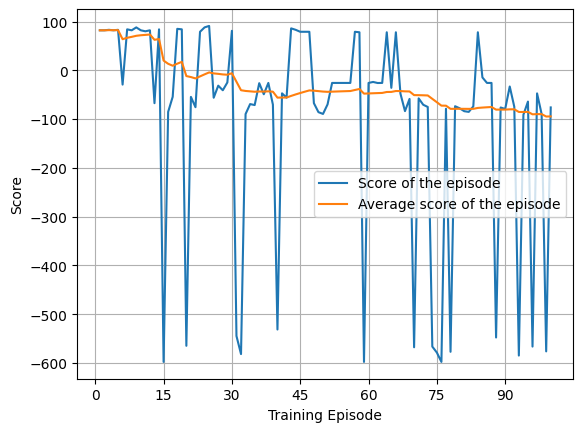

In [15]:
Episode = cfg.n_episodes
image_name = f"DQN_Scores{Episode}.png"
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores, label="Score of the episode")
plt.plot(np.arange(1, len(avg_scores)+1), avg_scores, label="Average score of the episode")
plt.grid()
plt.legend()
plt.ylabel('Score')
plt.xlabel(f'Training Episode')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

# plt.savefig((p_model/image_name))
plt.show()


In [16]:
for i in range(3):
    state = env.reset()
    for j in range(700):
        action = agent.act(state)  
        # ac.append(action)
        env.render()
        state, reward, done, _ = env.step(action)
        if done:
            break 
# print(get_unique_numbers(ac))
env.close()